Solves Wordle game (https://www.powerlanguage.co.uk/wordle/)


Required: Download Collins Scrabble words dictionary from following location:

https://drive.google.com/file/d/1oGDf1wjWp5RF_X9C7HoedhIWMh5uJs8s/view (Also available in github along with this notebook)

In [1]:
from collections import Counter, defaultdict
import copy
from typing import List, Optional, Dict, Tuple


In [2]:
def dedup_scorer(word, 
                 char_scores,
                 known_greys: List[str] = None, 
                 known_yellows: Dict[str,List[int]] = None) -> int:
    """
    When a char occurs multiple times in a word, this returns the score by counting it only in the most frequent position
    word: Current word for which score should be computed
    char_scores: Dictionary with each alphabet as key, and value is another dictionary with char position(0 to 4) as keys and word frequency in that position as values
    known_greys: List of alphabets that are known to be not present in the word. Response from wordle
    known_yellows: Dictionary with yellow colored alphabets as keys, and values as positions where they are known to be absent
    Returns: score with below logic
    Logic: If the word contains any char from known_greys or char from known_yellows with char in same position known to be invalid, score is automatically zero.
    Else:
    For every character, score is the no:of words where the character is seen in same position. 
    If a char is present multiple times in word, it is counted only once in the position where score is highest.
    These char level scores are summed up to give word score
    """
    chars = list(word)
    if known_greys:
        for char in chars:
            if char in known_greys:
                return 0
    if known_yellows:
        for char, pos_list in known_yellows.items():
            if char not in chars:
                return 0
            for pos in pos_list:
                if chars[pos] == char:
                    return 0
    if max([chars.count(char) for char in chars]) == 1:
        s=0
        for pos, char in enumerate(chars):
            s+=char_scores[char].get(pos,0)
    else:
        # A character is found more than once in the token. It gets counted only once - An exception if the score is 100000, indicating it is a green letter. i.e., known to be in that place.
        s=0
        char_counter = defaultdict(list)
        for pos, char in enumerate(chars):
            char_counter[char].append(pos)
        for char, pos_list in char_counter.items():
            max_score = 0
            for pos in pos_list:
                if char_scores[char].get(pos, 0) == 100000:
                    s+=100000
                elif char_scores[char].get(pos,0)>max_score:
                    max_score = char_scores[char][pos]
            s += max_score

    return s

def score_words_by_position(words_list: List[str], 
                            char_scores: Dict[str, Dict[int, int]],
                            known_greys: List[str] = None,
                            known_yellows: Dict[str,List[int]] = None):
    """
    For each word, score is from term frequency at that position. If word contains a word more than once, it gets only one score - whichever is highest.
    """
    word_scores = {}
    for word in words_list:
        word_scores[word] = dedup_scorer(word, char_scores, known_greys, known_yellows)
    return word_scores

def update_char_scores(char_scores_by_pos, wordle_word, wordle_response: Tuple[int]) -> Dict[str, Dict[int, int]]:
    new_scores = copy.deepcopy(char_scores_by_pos)
    for position, char in enumerate(wordle_word):
        if wordle_response[position] == 0:
            for pos in range(5):
                new_scores[char][pos] = 0
        elif wordle_response[position] == 1:
            new_scores[char][position] = 0
        elif wordle_response[position] == 2:
            new_scores[char][position] = 100000
    return new_scores
        

def update_greys(current_greys: List[str], token: str, wordle_response: List[int]):
    current_greys_upd = current_greys.copy()
    for pos, char in enumerate(list(token)):
        if char in current_greys_upd:
            # known info.
            continue
        elif wordle_response[pos] == 0:
            ## Check if the same char is present multiple times with different responses
            if max([score for position, score in enumerate(wordle_response) if token[position] == char]) ==0:
                current_greys_upd.append(char)
    return current_greys_upd

def update_yellows(current_yellows: Dict[str, List[int]], token: str, wordle_response: List[int]):
    current_yellows_upd = copy.deepcopy(current_yellows)
    for pos, char in enumerate(token):
        if wordle_response[pos] == 1:
            if char not in current_yellows_upd:
                current_yellows_upd[char] = []
            if pos not in current_yellows_upd[char]:
                current_yellows_upd[char].append(pos)
    return current_yellows_upd

In [3]:
with open("Collins Scrabble Words (2019).txt","r") as f:
    word_list = f.read().splitlines()
WORD_LENGTH = 5

valid_words = [word for word in word_list if len(word) == WORD_LENGTH]

In [4]:
def get_char_scores(word_list: List[str]):
    char_scores_by_position = defaultdict(dict)
    for word in word_list:
        for position, char in enumerate(list(word)):
            char_score_ = char_scores_by_position[char]
            if char_score_.get(position) is None:
                char_score_[position] = 0
            char_score_[position] += 1
    return char_scores_by_position

In [6]:
def guess_next_word(valid_words, known_greys, known_yellows, char_scores_by_position, current_guess=None, current_response=None):
    if current_guess is not None:
        char_scores_by_position = update_char_scores(char_scores_by_position, current_guess, current_response)
        known_greys = update_greys(known_greys, current_guess, current_response)
        known_yellows = update_yellows(known_yellows, current_guess, current_response)
    word_scores_by_position = score_words_by_position(valid_words, char_scores_by_position, known_greys, known_yellows)
    guess = Counter(word_scores_by_position).most_common()[0][0]
    return guess, char_scores_by_position, known_greys, known_yellows

In [10]:
char_scores_by_position = get_char_scores(valid_words)
known_greys = []
known_yellows = {}
guess, char_scores_by_position, known_greys, known_yellows = guess_next_word(valid_words, known_greys, known_yellows, char_scores_by_position)
n=1
print(f"Guess no {n}: {guess}")

Guess no 1: CARES


Enter above guess. Get response and **repeat below cell till you get the answer** by entering your response
* Response to be entered as list of integers.  Yellow = 1, Green = 2, Grey = 0. So for CARES if you get C as yellow, A as green, and rest as grey, response would be [1,2,0,0,0]


In [11]:
# Enter Wordle response as a list. Yellow = 1, Green = 2, Grey = 0. So for CARES if you get C as yellow, A as green, and rest as grey, response would be [1,2,0,0,0]
response = [1,0,1,0,0]
n+=1
guess, char_scores_by_position, known_greys, known_yellows = guess_next_word(valid_words, known_greys, known_yellows, char_scores_by_position, guess, response)
print(f"Guess no {n}: {guess}")

Guess no 2: ROCKY


In [12]:
# Enter Wordle response as a list. Yellow = 1, Green = 2, Grey = 0. So for CARES if you get C as yellow, A as green, and rest as grey, response would be [1,2,0,0,0]
response = [1,0,1,1,0]
n+=1
guess, char_scores_by_position, known_greys, known_yellows = guess_next_word(valid_words, known_greys, known_yellows, char_scores_by_position, guess, response)
print(f"Guess no {n}: {guess}")

Guess no 3: BRICK


In [13]:
# Enter Wordle response as a list. Yellow = 1, Green = 2, Grey = 0. So for CARES if you get C as yellow, A as green, and rest as grey, response would be [1,2,0,0,0]
response = [0,2,2,2,2]
n+=1
guess, char_scores_by_position, known_greys, known_yellows = guess_next_word(valid_words, known_greys, known_yellows, char_scores_by_position, guess, response)
print(f"Guess no {n}: {guess}")

Guess no 4: PRICK


Repeat above cell till correct answer

# Simulation 
To test effectiveness of the algo

In [10]:
def get_wordle_response(prediction:str, answer: str) -> List[int]:
    response = [None] * len(answer)
    pred_chars = list(prediction)
    answer_chars = list(answer)
    for pos, char in enumerate(pred_chars):
        if char == answer_chars[pos]:
            response[pos] = 2
            answer_chars[pos] = None
            pred_chars[pos] = None
    for pos, char in enumerate(pred_chars):
        if pred_chars[pos]:
            if char in answer_chars:
                response[pos] = 1
                answer_chars[answer_chars.index(char)] = None
            else:
                response[pos] = 0
    return response

def simulate_wordle(answer_word, valid_words):
    known_greys = []
    known_yellows = {}
    char_scores_by_position = get_char_scores(valid_words)
    word_scores_by_position = score_words_by_position(valid_words, char_scores_by_position, known_greys, known_yellows)
    guess = Counter(word_scores_by_position).most_common()[0][0]
    response = get_wordle_response(guess, answer_word)
    n_guesses = 1
    guess_list = [guess]
    while min(response)!=2:
        char_scores_by_position =  update_char_scores(char_scores_by_position, guess, response)
        known_greys = update_greys(known_greys, guess, response)
        known_yellows = update_yellows(known_yellows, guess, response)
        word_scores_by_position = score_words_by_position(valid_words, char_scores_by_position, known_greys, known_yellows)
        guess = Counter(word_scores_by_position).most_common()[0][0]
        guess_list.append(guess)
        response = get_wordle_response(guess, answer_word)
        n_guesses += 1
        if n_guesses > 10:
            break
    return guess_list

In [11]:
simulate_wordle("PANIC", valid_words)

['CARES', 'TALCY', 'PANIC']

In [12]:
import numpy as np
from tqdm import tqdm
import random

In [13]:
%%time
n_guesses = []
random_choices = random.choices(valid_words, k=500)
for word in tqdm(random_choices):
    word_seq = simulate_wordle(word, valid_words)
    n_guesses.append(len(word_seq))

100%|██████████| 500/500 [00:48<00:00, 10.31it/s]

CPU times: user 48.2 s, sys: 328 ms, total: 48.5 s
Wall time: 48.5 s


In [14]:
max(n_guesses)

11

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

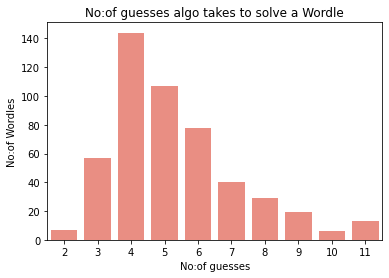

In [16]:
sns.barplot(x=list(Counter(n_guesses).keys()), y=list(Counter(n_guesses).values()), color="salmon")
plt.xlabel("No:of guesses")
plt.ylabel("No:of Wordles")
plt.title("No:of guesses algo takes to solve a Wordle");

In [17]:
print(f"{len([g for g in n_guesses if g<=6])/len(n_guesses)* 100:.2f} % of words in the dictionary are solvable by this method")

78.60 % of words in the dictionary are solvable by this method


In [18]:
print(f"{np.mean([g for g in n_guesses if g<=6]):.2f} is avg no:of takes when it can actually solve the word")

4.49 is avg no:of takes when it can actually solve the word


### DEBUG

In [19]:
incorrect_words = 0
for pos, n in enumerate(n_guesses):
    if n>6:
        incorrect_words+=1
        print(random_choices[pos])
    if incorrect_words>5:
        break

VOLED
CAREX
GROKS
HELLS
DREYS
SPANE


In [20]:
simulate_wordle("WEEKS", valid_words)

['CARES', 'SENTS', 'PEELS', 'MEEDS', 'BEEFS', 'GEEKS', 'WEEKS']

In [21]:
char_scores_by_position.get("E")

{3: 0, 4: 0, 2: 0, 1: 0, 0: 0}

In [22]:
answer_word = "WEEKS"
known_greys = []
known_yellows = {}
char_scores_by_position = get_char_scores(valid_words)
word_scores_by_position = score_words_by_position(valid_words, char_scores_by_position, known_greys, known_yellows)
guess = Counter(word_scores_by_position).most_common()[0][0]
response = get_wordle_response(guess, answer_word)
n_guesses = 1
guess_list = [guess]
while min(response)!=2:
    char_scores_by_position =  update_char_scores(char_scores_by_position, guess, response)
    known_greys = update_greys(known_greys, guess, response)
    known_yellows = update_yellows(known_yellows, guess, response)
    print(guess)
    print(response)
    print(known_greys)
    print(known_yellows)
    word_scores_by_position = score_words_by_position(valid_words, char_scores_by_position, known_greys, known_yellows)
    guess = Counter(word_scores_by_position).most_common()[0][0]
    guess_list.append(guess)
    response = get_wordle_response(guess, answer_word)
    n_guesses += 1
    if n_guesses > 10:
        break

CARES
[0, 0, 0, 1, 2]
['C', 'A', 'R']
{'E': [3]}
SENTS
[0, 2, 0, 0, 2]
['C', 'A', 'R', 'N', 'T']
{'E': [3]}
PEELS
[0, 2, 2, 0, 2]
['C', 'A', 'R', 'N', 'T', 'P', 'L']
{'E': [3]}
MEEDS
[0, 2, 2, 0, 2]
['C', 'A', 'R', 'N', 'T', 'P', 'L', 'M', 'D']
{'E': [3]}
BEEFS
[0, 2, 2, 0, 2]
['C', 'A', 'R', 'N', 'T', 'P', 'L', 'M', 'D', 'B', 'F']
{'E': [3]}
GEEKS
[0, 2, 2, 2, 2]
['C', 'A', 'R', 'N', 'T', 'P', 'L', 'M', 'D', 'B', 'F', 'G']
{'E': [3]}


## Case against above approach

In [15]:
[w for w in valid_words if w.endswith("RICK")]

['BRICK', 'CRICK', 'ERICK', 'PRICK', 'TRICK', 'WRICK']

In [21]:
n_word_matches = {}
chars_list = "BCEPTW"
for word in valid_words:
    n_word_matches[word] = len(set([n for n in word if n in chars_list]))

In [22]:
Counter(n_word_matches).most_common(10)

[('BECAP', 4),
 ('BEPAT', 4),
 ('BEWET', 4),
 ('BICEP', 4),
 ('BOWET', 4),
 ('CLEPT', 4),
 ('CREPT', 4),
 ('EPACT', 4),
 ('PEWIT', 4),
 ('SPECT', 4)]

**If after first guess, we found "RICK" to be four characters in place apart from the first, we have 6 possible guesses. It is luck dependent that we get it right, and 1/6 chance we need 6 tries**
Instead, first guess can be BICEP. We will know the correct word with a 4/6 probability. So 4/6 prob that we need 2 chances (1st for exploration, 2nd for actual guess). If actual word is TRICK, we can use 2nd chance to try TRICK. 50% probability it may fail, but we now know the word for sure. So 1/6 prob that we need 3 guesses, and 5/6 chance we need 2 guesses. 